# 1. Import - 환경설정

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pyarrow.parquet as pq
import tqdm
import optuna
import gc
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

# test 데이터 준비 (샘플로 train에서 분리)
from sklearn.model_selection import train_test_split

# 모델 학습 및 평가
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score

* 최적화 관련 코드

In [2]:
# 메모리를 32비트로 변환
def optimize_memory(df):
    for col in df.select_dtypes(include=['number']).columns:
        # 정수형은 가능한 가장 작은 타입으로 (int8, int16 등)
        if df[col].dtype == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        # 실수형은 float32로
        elif df[col].dtype == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
    return df

# 2. 파일을 불러오고, 폴더별로 합치기

In [3]:
# 함수로 만들어서 넣어버리자 그냥
# 각 폴더명 딕셔너리
HOME = os.getcwd()
def makeFileList(option = "train"):
    folder_name = {1:"1.회원정보", 2:"2.신용정보", 3:"3.승인매출정보", 4:"4.청구입금정보", 5:"5.잔액정보", 6:"6.채널정보", 7:"7.마케팅정보", 8:"8.성과정보"}

    # 현재 디렉터리
    HOME = os.getcwd()

    # 폴더 리스트를 생성하고 폴더 경로들을 리스트로 저장하기
    folder_list = []
    for value in folder_name.values():
        folder_list.append(os.path.join(HOME, "data", option, value))
    print(len(folder_list))

    # 폴더 내 파일 리스트 읽어오기
    fileNameList = {}
    for i in range(len(folder_list)):
        fileNameList[i+1] = os.listdir(folder_list[i])
    print(fileNameList)

    # 파일 경로 리스트 생성
    filePathList = {}
    temp = []
    for i in range(len(folder_list)):
        for j in range(len(fileNameList[i+1])):
            temp.append(os.path.join(folder_list[i], fileNameList[i+1][j]))
        filePathList[i+1] = temp
        temp = []

    return filePathList

In [4]:
# 240만개의 파일을 이어 붙이기
# 각 폴더에 들어있는 파일들 중 같은 달의 열을 모두 합침
def load_cat(i, filePathList):
    print("현재 진행 상황 : {}".format(i))
    df = optimize_memory(pd.read_parquet(filePathList[i][0]))
    for j in range(1,6):
        print("Debugging1")
        df = pd.concat([df, optimize_memory(pd.read_parquet(filePathList[i][j]))])
    return df

# 공통된 쓸모없는 column 제거 함수=
def drop_useless(df):
    df = df.drop(columns = ["기준년월", "ID"])
    return df
# target인 Segment가 없을시 Segment 추가
def add_target(df, filePathList):# target이 존재하지 않는 df, target명(문자열)
    temp_df = pd.read_parquet(filePathList[1][0])
    for i in range(1, 6):
        temp_df = pd.concat([temp_df, pd.read_parquet(filePathList[1][i])])
    df = pd.merge(temp_df[["기준년월", "ID", "Segment"]], df, on = ["기준년월","ID"],how = "left")
    return df

# 파일을 불러오는 함수
def make_df(i, option = False):# option이 True면 Test데이터도 불러오게 하자.

    # train 데이터 불러오기
    train = makeFileList()
    test = makeFileList(option = "test")
    train = load_cat(i, train)

    # test 데이터 불러오기
    if option == "all":
        train = pd.DataFrame()
        for i in range(1, 9):
            train = pd.concat([train, drop_useless(load_cat(i, makeFileList()))], axis = 1)    
        test = pd.DataFrame()
        for i in range(1, 9):
            test = pd.concat([test, drop_useless(load_cat(i, makeFileList(option = "test")))], axis = 1)
    elif option:
        train = drop_useless(add_target(train, makeFileList()))
        test = drop_useless(load_cat(i, test))

    
    # option 이 True 라면 concat해서 붙여넣기 : if로 하지 않으면 앞에 test를 선언했기 때문에 오류 날 것
    if option:
        print(train.shape)
        print(test.shape)

        result = pd.concat([train, test], ignore_index=True)
        print(result.shape)
        return result
    else :
        print(train.shape)
        if (i > 1) & (i <= 6): train = add_target(train, makeFileList())
        elif i == 1: return drop_useless(train)
        else: print("숫자가 아니거나 할당 없는 카테고리입니다.")
        return drop_useless(train)
    # i 가 1보다 크고 1보다 작을때 사용



# 데이터프레임에서 파라미터를 입력하면 그 파라미터가 포함된 column들을 가져와 새로운 데이터프레임을 반환함
# 연관성 있는 column들을 얻어오기 위해서 사용한다.
def find_R(df, param1):
    columns = list(df.columns)
    new_columns = []
    for column in columns:
        if param1 in column:
            new_columns.append(column)
    return pd.DataFrame(df[new_columns])

In [5]:
# 0과 1로 이루어진 데이터들 중, 상대적으로 부족한 A, B에 대해서 확실히 평가를 끌어내 줄 수 있지 않을까 싶어서 가져온 자료
def plot_segment_comparison(df, column):
    """
    Segment와 지정된 column의 관계를 stacked bar chart와 heatmap으로 시각화
    1행 2열 subplot
    
    Parameters:
    -----------
    df : DataFrame
        데이터프레임
    column : str
        비교할 column 이름 (예: "회원여부_연체")
    """
    df_reset = df.reset_index(drop=True)
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
    sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus": False},
        style='darkgrid')
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # 1. Stacked Bar Chart (왼쪽)
    crosstab_pct = pd.crosstab(df_reset["Segment"], df_reset[column], normalize='index') * 100
    crosstab_pct.plot(kind='bar', stacked=True, ax=axes[0], color=['#2ecc71', '#e74c3c'])
    axes[0].set_title(f"Segment별 {column} 비율 (100%)", fontsize=12, fontweight='bold')
    axes[0].set_xlabel("Segment (0=E, 1=D, 2=C, 3=B, 4=A)")
    axes[0].set_ylabel("비율 (%)")
    axes[0].legend(title=column, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 2. HeatMap (오른쪽)
    crosstab = pd.crosstab(df_reset["Segment"], df_reset[column])
    sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1], cbar_kws={'label': '빈도'})
    axes[1].set_title(f"Segment별 {column} 매트릭스", fontsize=12, fontweight='bold')
    axes[1].set_xlabel(column)
    axes[1].set_ylabel("Segment (0=E, 1=D, 2=C, 3=B, 4=A)")
    
    plt.tight_layout()
    plt.show()

# 사용 예시
# plot_segment_comparison(df, "회원여부_연체")
# plot_segment_comparison(df, "가입통신회사코드")

## 사용하면 되는 함수
- make_df(i, option = False)
    - 데이터를 불러와 데이터 프레임을 만들어 내는 함수
    - i는 폴더를 불러오기 위한 변수
    - 기본적으로 option = False
    - option에 아무 값이나 넣으면 True가 되고, 그러면 해당하는 Test값이 들어간다.
    - option에 "all"이 들어가면 모든 데이터를 합쳐서 만들어줌

In [6]:
# 만들어둔 함수를 통해, 불러오고 싶은 폴더를 입력하면 데이터를 한번에 불러와준다.
df = make_df(2, option = "all")

8
{1: ['201807_train_회원정보.parquet', '201808_train_회원정보.parquet', '201809_train_회원정보.parquet', '201810_train_회원정보.parquet', '201811_train_회원정보.parquet', '201812_train_회원정보.parquet'], 2: ['201807_train_신용정보.parquet', '201808_train_신용정보.parquet', '201809_train_신용정보.parquet', '201810_train_신용정보.parquet', '201811_train_신용정보.parquet', '201812_train_신용정보.parquet'], 3: ['201807_train_승인매출정보.parquet', '201808_train_승인매출정보.parquet', '201809_train_승인매출정보.parquet', '201810_train_승인매출정보.parquet', '201811_train_승인매출정보.parquet', '201812_train_승인매출정보.parquet'], 4: ['201807_train_청구정보.parquet', '201808_train_청구정보.parquet', '201809_train_청구정보.parquet', '201810_train_청구정보.parquet', '201811_train_청구정보.parquet', '201812_train_청구정보.parquet'], 5: ['201807_train_잔액정보.parquet', '201808_train_잔액정보.parquet', '201809_train_잔액정보.parquet', '201810_train_잔액정보.parquet', '201811_train_잔액정보.parquet', '201812_train_잔액정보.parquet'], 6: ['201807_train_채널정보.parquet', '201808_train_채널정보.parquet', '201809_train_채널정보.parquet',

# 3. 전처리 - concat & merge 및 Feature Engineering

In [7]:
import pandas as pd
import numpy as np
import gc

# from google.colab import drive
# drive.mount('/content/drive')

# 전처리 및 Feauture Engineering

### 직접했던 피쳐엔지니어링 (1)
- 폴더 1 기반 피쳐엔지니어링
- catboost 모델의 피처 importance를 기반으로, 분류가 가능한 피쳐를 선별해 사용
- catboost 모델은 XGboost나 LGBW모델과 같은 트리 모델과는 다르게 적은 양의 데이터라도 확실히 구분되는 특성을 가진 데이터가 있다면 이를 중요하게 생각하고 반영하는 특성이 있다.
- 예를 들어서, 직접 만든 특성인 **'회원_이용가능_점수'** 항목의 시각화를 확인해보면 다음과 같다.
- 시각화된 왼쪽 자료를 보면 그다지 상관관계가 없어보이는 자료 같지만, 오른쪽을 보면 A, B에서는 회원 이용가능 점수가 0에서는 존재하지 않고, 1에서도 거의 없다고 볼 수 있다. 즉, A,B와 C,D,E를 구분할 수 있는 자료이기 때문에 catboost에서는 더 많은 참고를 한다는 것이다.
- 이 사실을 기반으로 하여 catboost 기반으로 모델링을 준비했었다.

C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\4093047334.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['카드_즉시가용_비율'] = df['소지카드수_이용가능_신용'] / (df['소지카드수_유효_신용'] + 1)
C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\4093047334.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['누적탈회밀도'] = df['탈회횟수_누적'] / (df['최종탈회후경과월'] + 1)
C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\4093047334.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

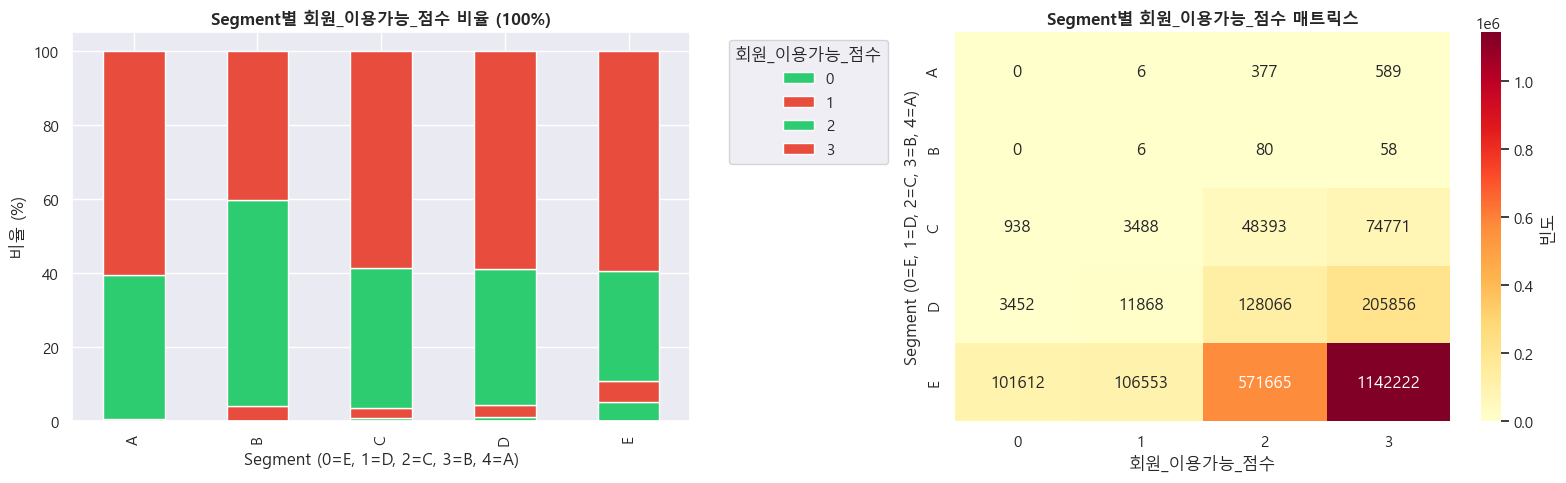

In [8]:
def calculate_month_diff(target_ym):
    # 연도 차이와 월 차이를 계산하여 잔여 개월수 도출
    target_year = target_ym // 100
    target_month = target_ym % 100
    
    current_year = 2026
    current_month = 2
    return (target_year - current_year) * 12 + (target_month - current_month)

def Folder1_Feature(df):
    # 소지카드수를 통한 즉시 사용 가능한 비율
    df['카드_즉시가용_비율'] = df['소지카드수_이용가능_신용'] / (df['소지카드수_유효_신용'] + 1)
    
    # 여기서는 '고객의 금융 활동 기간 중 탈회가 얼마나 잦았나'를 측정합니다.
    df['누적탈회밀도'] = df['탈회횟수_누적'] / (df['최종탈회후경과월'] + 1)
    
    # 탈회 원격도: 전체 탈회 중 과거(1년 전) 비중 (A, B 타겟용)
    df['탈회원격도'] = (df['탈회횟수_누적'] - df['탈회횟수_발급1년이내']) / (df['탈회횟수_누적'] + 1)
    
    # 활동 안정성: 마지막 탈회 후 얼마나 오래 버티고 있는가
    df['활동안정성'] = df['최종탈회후경과월'] / (df['입회경과개월수_신용'] + 1)
    
    # 시계열 데이터로 이루어진 데이터를 그냥 월단위로 조절해버리기
    df['잔여유효개월_실이용'] = df['최종유효년월_신용_이용'].apply(calculate_month_diff)

    # 카드사용시 CA, 카드론의 이용가능을 통한 분류 기준 추가
    df['회원_이용가능_점수'] = (
    (df['회원여부_이용가능'] == 1).astype(int) + 
    (df['회원여부_이용가능_CA'] == 1).astype(int)+ 
    (df['회원여부_이용가능_카드론'] == 1).astype(int))
    df = df.drop("회원여부_이용가능", axis = 1)
    df = df.drop("회원여부_이용가능_CA", axis = 1)
    df = df.drop("회원여부_이용가능_카드론", axis = 1)
    return df

df = Folder1_Feature(df)
plot_segment_comparison(df, '회원_이용가능_점수')

### 2nd 코드 리뷰 - 피쳐엔지니어링

#### 1. 이진화

In [9]:
# 가입통신회사코드 → 가입통신회사_S사여부
df['가입통신회사_S사여부'] = (df['가입통신회사코드'] == 'S사').astype(int)
df = df.drop(columns=['가입통신회사코드'])

# 직장시도명 → 직장_수도권여부
df['직장_수도권여부'] = df['직장시도명'].isin(['서울', '경기']).astype(int)
df = df.drop(columns=['직장시도명'])

# 거주시도명 → 거주지_수도권여부
df['거주지_수도권여부'] = df['거주시도명'].isin(['서울', '경기']).astype(int)
df = df.drop(columns=['거주시도명'])

# 연회비발생카드수_B0M → 연회비발생카드수_B0M_이진
df['연회비발생카드수_B0M_이진'] = df['연회비발생카드수_B0M'].isin(['1개이상']).astype(int)
df = df.drop(columns=['연회비발생카드수_B0M'])

# 'RV전환가능여부' → 'RV전환불가능여부'
df['RV_전환가능여부_이진'] = (df['RV전환가능여부'] == 'N').astype(int)
df = df.drop(columns='RV전환가능여부'
)

#‘한도증액횟수_R12M’ → '한도증액_R12M_여부': '0회' → 0, '1회이상' → 1
df['한도증액_R12M_여부'] = df['한도증액횟수_R12M'].map({
    '0회': 0,
    '1회이상': 1
    }).astype(int)
df.drop(columns=['한도증액횟수_R12M'], inplace=True)

# '카드론동의여부': 'Y' → 1, 'N' → 0
df['카드론동의여부'] = df['카드론동의여부'].map({
    'Y': 1,
    'N': 0
    }).astype(int)

# '한도심사요청건수' → '한도심사요청여부': '0회' → 0, '1회이상' → 1
df['한도심사요청여부'] = df['한도심사요청건수'].map({
    '0회': 0,
    '1회이상': 1
    }).astype(int)
df.drop(columns=['한도심사요청건수'], inplace=True)

# '카드론이용여부' 변수 생성
df['카드론이용여부'] = (
    (df['최초카드론이용경과월'] != 999) &
    (df['최종카드론이용경과월'] != 999)
).astype(int)



C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\1128169374.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['가입통신회사_S사여부'] = (df['가입통신회사코드'] == 'S사').astype(int)
C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\1128169374.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['직장_수도권여부'] = df['직장시도명'].isin(['서울', '경기']).astype(int)
C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\1128169374.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which

In [10]:

# 'RV실사용여부' 변수 추가
df['RV실사용여부'] = (df['RV약정청구율'] > 0).astype(int)

# '강제한도감액횟수_2회이상여부' 변수 추가
df['강제한도감액횟수_2회이상여부'] = (df['강제한도감액횟수_R12M'] > 1).astype(int)

# '강제한도감액금액_R12M_3이상여부' 변수 추가
df['강제한도감액금액_R12M_3이상여부'] = (df['강제한도감액금액_R12M'] > 2).astype(int)

# '상향가능CA한도금액_1여부' 변수 추가
df['상향가능CA한도금액_1여부'] = (df['상향가능CA한도금액'] == 1).astype(int)

C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\3707840474.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['RV실사용여부'] = (df['RV약정청구율'] > 0).astype(int)
C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\3707840474.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['강제한도감액횟수_2회이상여부'] = (df['강제한도감액횟수_R12M'] > 1).astype(int)
C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\3707840474.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

#### 2. 매핑

In [11]:
# 자발한도감액횟수_R12M: '0회' → 0, '1회' → 1, '2회' → 2
df['자발한도감액횟수_R12M'] = (
    df['자발한도감액횟수_R12M']
    .str.replace('회', '', regex=False)  # '회' 제거
    .astype(int)  # 바로 int로 변환!
)

df['할인건수_R3M'] = df['할인건수_R3M'].map({'1회 이상': 0, '10회 이상': 1, '20회 이상': 2,'30회 이상': 3, '40회 이상': 4})
df['할인건수_B0M'] = df['할인건수_B0M'].map({'1회 이상': 0, '10회 이상': 1})

df['인입횟수_ARS_R6M'] = df['인입횟수_ARS_R6M'].map({'1회 이상': 0, '10회 이상': 1})
df['이용메뉴건수_ARS_R6M'] = df['이용메뉴건수_ARS_R6M'].map({'1회 이상': 0, '10회 이상': 1, '20회 이상': 2, '30회 이상': 3})
df['방문횟수_PC_R6M'] = df['방문횟수_PC_R6M'].map({'1회 이상': 0, '10회 이상': 1, '20회 이상': 2, '30회 이상': 3, '40회 이상': 4})
df['방문일수_PC_R6M'] = df['방문일수_PC_R6M'].map({'1회 이상': 0, '10회 이상': 1, '20회 이상': 2, '30회 이상': 3})
df['방문횟수_앱_R6M'] = df['방문횟수_앱_R6M'].map({'1회 이상': 0, '10회 이상': 1, '20회 이상': 2, '30회 이상': 3, '40회 이상': 4,
                                                                     '50회 이상': 5, '60회 이상': 6, '70회 이상': 7, '80회 이상': 8})


df['캠페인접촉건수_R12M'] = df['캠페인접촉건수_R12M'].map({'1회 이상': 0, '5회 이상': 1,
                                                                             '10회 이상': 2,'15회 이상': 3, '20회 이상': 4, '25회 이상': 5})
                                                                             
df['캠페인접촉일수_R12M'] = df['캠페인접촉일수_R12M'].map({'1일 이상': 0, '5일 이상': 1, '10일 이상': 2,
                                                                             '15일 이상': 3, '20일 이상': 4})                                                                   


#### 3. 파생변수 생성

In [12]:
# '카드이용한도금액_A수준복합' 변수 추가

a_limit = df[df['Segment'] == 'A']['카드이용한도금액_B1M']
q1 = a_limit.quantile(0.25)
q3 = a_limit.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
a_no_outlier = a_limit[(a_limit >= lower_bound) & (a_limit <= upper_bound)]
a_B1M = a_no_outlier.min()
print(f"A의 이상치 제외 후 최솟값: {a_B1M:,}")  # 170,344

a_limit = df[df['Segment'] == 'A']['카드이용한도금액_B2M']
q1 = a_limit.quantile(0.25)
q3 = a_limit.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
a_no_outlier = a_limit[(a_limit >= lower_bound) & (a_limit <= upper_bound)]
a_B2M = a_no_outlier.min()
print(f"A의 이상치 제외 후 최솟값: {a_B2M:,}")  # 170,344

def classify_dual_limit(row):
    b1 = row['카드이용한도금액_B1M'] >= a_B1M
    b2 = row['카드이용한도금액_B2M'] >= a_B2M
    if b1 and b2:
        return 2     # 둘 다 170,344 이상
    elif b1 or b2:
        return 1     # 하나만 170,344 이상
    else:
        return 0    # 둘 다 170,344 미만

df['카드이용한도금액_A수준복합'] = df.apply(classify_dual_limit, axis=1)

A의 이상치 제외 후 최솟값: 170,344
A의 이상치 제외 후 최솟값: 170,344


C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\3389455459.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['카드이용한도금액_A수준복합'] = df.apply(classify_dual_limit, axis=1)


In [13]:
#  업종별 변수

# '_n순위업종_AB' 변수 추가 (상관계수 -0.3030)

'''
- 1순위 업종이 쇼핑	+1
- 2순위 업종이 사교활동	+1
- 2순위 업종이 교육	+0.5
- 2순위 업종이 의료	+1.5 (A, B에서 더 강하게 나타나므로)
- 3순위 업종이 사교활동	+1
- 3순위 업종이 의료	+1.5 (A, B에서 더 강하게 나타나므로)

- 2순위 업종이 없음 -1
- 3순위 업종이 없음 -1
- 2순위 업종이 교통 -0.5
- 2순위 업종이 납부 -0.5
'''

def compute_ab_score(row):
    score = 0
    # 가점 조건
    if row['_1순위업종'] == '쇼핑':
        score += 1
    if row['_2순위업종'] == '사교활동':
        score += 1
    if row['_2순위업종'] == '교육':
        score += 0.5
    if row['_2순위업종'] == '의료':
        score += 1
    if row['_3순위업종'] == '사교활동':
        score += 1
    if row['_3순위업종'] == '의료':
        score += 1

    # 감점 조건
    if row['_2순위업종'] == '없음':
        score -= 1
    if row['_3순위업종'] == '없음':
        score -= 1
    if row['_2순위업종'] == '교통':
        score -= 0.5
    if row['_2순위업종'] == '납부':
        score -= 0.5

    return score

df['_n순위업종_AB'] = df.apply(compute_ab_score, axis=1)

# '_n순위쇼핑업종_AB' 변수 추가 (상관계수 -0.3304)

'''
- 1순위 쇼핑업종이 온라인 +1
- 2순위 쇼핑업종이 도소매 +1
- 3순위 쇼핑업종이 마트 +1

- 1순위 쇼핑업종이 없음 -1
- 2순위 쇼핑업종이 슈퍼마켓 -0.5
- 2순위 쇼핑업종이 없음 -0.5
- 3순위 쇼핑업종이 없음 -1
'''

def compute_ab_score(row):
    score = 0
    # 가점 조건
    if row['_1순위쇼핑업종'] == '온라인':
        score += 1
    if row['_2순위쇼핑업종'] == '도소매':
        score += 1
    if row['_3순위쇼핑업종'] == '마트':
        score += 1

    # 감점 조건
    if row['_1순위쇼핑업종'] == '없음':
        score -= 1
    if row['_2순위쇼핑업종'] == '슈퍼마켓':
        score -= 0.5
    if row['_2순위쇼핑업종'] == '없음':
        score -= 0.5
    if row['_3순위쇼핑업종'] == '없음':
        score -= 1

    return score

df['_n순위쇼핑업종_AB'] = df.apply(compute_ab_score, axis=1)

# '_n순위교통업종_AB' 변수 추가 (상관계수 -0.34514)

'''
- 1순위 교통업종이 주유 +1
- 2순위 교통업종이 정비 +1
- 3순위 교통업종이 택시 +0.5
- 3순위 교통업종이 정비 +0.5
- 3순위 교통업종이 철도버스 +0.5

- 1순위 교통업종이 없음 -1
- 2순위 교통업종이 없음 -1
'''

def compute_ab_score(row):
    score = 0
    # 가점 조건
    if row['_1순위교통업종'] == '주유':
        score += 1
    if row['_2순위교통업종'] == '정비':
        score += 1
    if row['_3순위교통업종'] == '택시':
        score += 0.5
    if row['_3순위교통업종'] == '정비':
        score += 0.5
    if row['_3순위교통업종'] == '철도버스':
        score += 0.5

    # 감점 조건
    if row['_1순위교통업종'] == '없음':
        score -= 1
    if row['_2순위교통업종'] == '없음':
        score -= 1

    return score

df['_n순위교통업종_AB'] = df.apply(compute_ab_score, axis=1)

# '_n순위여유업종_AB' 변수 추가 (상관계수 -0.26628)

'''
- 1순위 여유업종이 운동 +1
- 1순위 여유업종이 항공 +1
- 2순위 여유업종이 숙박 +1
- 2순위 여유업종이 공연 +1
- 3순위 여유업종이 숙박 +1
- 3순위 여유업종이 공연 +1
- 3순위 여유업종이 여유기타 +1

- 1순위 여유업종이 없음 -0.5
- 2순위 여유업종이 없음 -0.5
- 3순위 여유업종이 없음 -0.5
'''

def compute_ab_score(row):
    score = 0
    # 가점 조건
    if row['_1순위여유업종'] == '운동':
        score += 1
    if row['_1순위여유업종'] == '항공':
        score += 1
    if row['_2순위여유업종'] == '숙박':
        score += 1
    if row['_2순위여유업종'] == '공연':
        score += 1
    if row['_3순위여유업종'] == '숙박':
        score += 1
    if row['_3순위여유업종'] == '공연':
        score += 1
    if row['_3순위여유업종'] == '여유기타':
        score += 1

    # 감점 조건
    if row['_1순위여유업종'] == '없음':
        score -= 0.5
    if row['_2순위여유업종'] == '없음':
        score -= 0.5
    if row['_3순위여유업종'] == '없음':
        score -= 0.5

    return score

df['_n순위여유업종_AB'] = df.apply(compute_ab_score, axis=1)

# '_n순위납부업종_AB' 변수 추가 (상관계수 -0.2579)

'''
- 1순위 납부업종이 납부기타 +0.5
- 1순위 납부업종이 보험료 +0.5
- 1순위 납부업종이 통신비 +0.5
- 2순위 납부업종이 납부기타 +0.5
- 2순위 납부업종이 보험료 +0.5
- 2순위 납부업종이 통신비 +0.5
- 3순위 납부업종이 납부기타 +0.5

- 1순위 납부업종이 없음 -0.5
- 2순위 납부업종이 없음 -0.5
- 3순위 납부업종이 없음 -0.5
'''

def compute_ab_score(row):
    score = 0
    # 가점 조건
    if row['_1순위납부업종'] == '납부기타':
        score += 0.5
    if row['_1순위납부업종'] == '보험료':
        score += 0.5
    if row['_1순위납부업종'] == '통신비':
        score += 0.5
    if row['_2순위납부업종'] == '납부기타':
        score += 0.5
    if row['_2순위납부업종'] == '보험료':
        score += 0.5
    if row['_2순위납부업종'] == '통신비':
        score += 0.5
    if row['_3순위납부업종'] == '납부기타':
        score += 0.5

    # 감점 조건
    if row['_1순위납부업종'] == '없음':
        score -= 0.5
    if row['_2순위납부업종'] == '없음':
        score -= 0.5
    if row['_3순위납부업종'] == '없음':
        score -= 0.5

    return score

df['_n순위납부업종_AB'] = df.apply(compute_ab_score, axis=1)

# '_n순위@@업종_AB' 5개 변수 합친 변수 '_n순위업종_AB_총합' 추가 (상관계수 -0.3927)
df['_n순위업종_AB_총합'] = (
    df['_n순위업종_AB'] +
    df['_n순위쇼핑업종_AB'] +
    df['_n순위교통업종_AB'] +
    df['_n순위여유업종_AB'] +
    df['_n순위납부업종_AB']
)

# '_n순위@@업종' 변수 삭제
cols_to_drop = [
    '_1순위업종','_2순위업종','_3순위업종',
    '_1순위쇼핑업종','_2순위쇼핑업종','_3순위쇼핑업종',
    '_1순위교통업종','_2순위교통업종','_3순위교통업종',
    '_1순위여유업종','_2순위여유업종','_3순위여유업종',
    '_1순위납부업종','_2순위납부업종','_3순위납부업종'
]

df.drop(columns=cols_to_drop, inplace=True)

# '이용금액대_점수' 변수 생성 (상관계수 -0.6026)
amount_mapping = {
    '01.100만원+': 18,
    '02.50만원+': 5,
    '03.30만원+': 2,
    '04.10만원+': 2,
    '05.10만원-': 1,
    '09.미사용': 1
}

df['이용금액대_점수'] = df['이용금액대'].map(amount_mapping)

# 원래 변수 '이용금액대' 삭제
df = df.drop(columns=['이용금액대'])

# '이용여부_@@' 변수 생성
df['이용여부_기본']   = (df['최종이용일자_기본'] != 10101).astype(int)
df['이용여부_신판']   = (df['최종이용일자_신판'] != 10101).astype(int)
df['이용여부_CA']    = (df['최종이용일자_CA'] != 10101).astype(int)
df['이용여부_카드론'] = (df['최종이용일자_카드론'] != 10101).astype(int)
df['이용여부_체크']   = (df['최종이용일자_체크'] != 10101).astype(int)
df['이용여부_일시불'] = (df['최종이용일자_일시불'] != 10101).astype(int)
df['이용여부_할부']   = (df['최종이용일자_할부'] != 10101).astype(int)

# 원래 '최종이용일자_@@' 변수 삭제
for i in ['최종이용일자_기본','최종이용일자_신판','최종이용일자_CA','최종이용일자_카드론','최종이용일자_체크','최종이용일자_일시불','최종이용일자_할부']:
  df = df.drop(columns=[i])



C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\3397345144.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['_n순위업종_AB'] = df.apply(compute_ab_score, axis=1)
C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\3397345144.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['_n순위쇼핑업종_AB'] = df.apply(compute_ab_score, axis=1)
C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\3397345144.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

In [14]:
# 건수별 평균 이용금액 (B0M만) (R12,6,3M 제외)

##### 이용건수 #####

# 데이터 값이 모두 같은 변수 제거
df = df.drop(columns=['이용건수_부분무이자_B0M'])

# '이용건수_신용_B0M' 변수 값 보정
df['이용건수_신용_B0M'] = df['이용건수_신용_B0M'] + df['이용건수_카드론_B0M']



##### 이용금액 #####

# 데이터 값이 모두 같은 변수 제거
df = df.drop(columns=['이용금액_부분무이자_B0M'])

# '이용금액_신용_B0M', '이용금액_신판_B0M' 변수 생성
df['이용금액_신용_B0M'] = df['이용금액_일시불_B0M'] + df['이용금액_할부_B0M'] + df['이용금액_CA_B0M'] + df['이용금액_카드론_B0M']
df['이용금액_신판_B0M'] = df['이용금액_일시불_B0M'] + df['이용금액_할부_B0M']

# 건수별평균이용금액 변수 생성
df['건수별평균이용금액_신용_B0M'] = np.where(
    (df['이용건수_신용_B0M'] == 0) | (df['이용금액_신용_B0M'] == 0), 0,
    df['이용금액_신용_B0M'] / df['이용건수_신용_B0M'].abs()
)

df['건수별평균이용금액_신판_B0M'] = np.where(
    (df['이용건수_신판_B0M'] == 0) | (df['이용금액_신판_B0M'] == 0), 0,
    df['이용금액_신판_B0M'] / df['이용건수_신판_B0M'].abs()
)

df['건수별평균이용금액_일시불_B0M'] = np.where(
    (df['이용건수_일시불_B0M'] == 0) | (df['이용금액_일시불_B0M'] == 0), 0,
    df['이용금액_일시불_B0M'] / df['이용건수_일시불_B0M'].abs()
)

df['건수별평균이용금액_할부_B0M'] = np.where(
    (df['이용건수_할부_B0M'] == 0) | (df['이용금액_할부_B0M'] == 0), 0,
    df['이용금액_할부_B0M'] / df['이용건수_할부_B0M'].abs()
)

df['건수별평균이용금액_할부_유이자_B0M'] = np.where(
    (df['이용건수_할부_유이자_B0M'] == 0) | (df['이용금액_할부_유이자_B0M'] == 0), 0,
    df['이용금액_할부_유이자_B0M'] / df['이용건수_할부_유이자_B0M'].abs()
)

df['건수별평균이용금액_할부_무이자_B0M'] = np.where(
    (df['이용건수_할부_무이자_B0M'] == 0) | (df['이용금액_할부_무이자_B0M'] == 0), 0,
    df['이용금액_할부_무이자_B0M'] / df['이용건수_할부_무이자_B0M'].abs()
)

df['건수별평균이용금액_CA_B0M'] = np.where(
    (df['이용건수_CA_B0M'] == 0) | (df['이용금액_CA_B0M'] == 0), 0,
    df['이용금액_CA_B0M'] / df['이용건수_CA_B0M'].abs()
)

df['건수별평균이용금액_체크_B0M'] = np.where(
    (df['이용건수_체크_B0M'] == 0) | (df['이용금액_체크_B0M'] == 0), 0,
    df['이용금액_체크_B0M'] / df['이용건수_체크_B0M'].abs()
)

df['건수별평균이용금액_카드론_B0M'] = np.where(
    (df['이용건수_카드론_B0M'] == 0) | (df['이용금액_카드론_B0M'] == 0), 0,
    df['이용금액_카드론_B0M'] / df['이용건수_카드론_B0M'].abs()
)


C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\2011737505.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['이용금액_신용_B0M'] = df['이용금액_일시불_B0M'] + df['이용금액_할부_B0M'] + df['이용금액_CA_B0M'] + df['이용금액_카드론_B0M']
C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\2011737505.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['이용금액_신판_B0M'] = df['이용금액_일시불_B0M'] + df['이용금액_할부_B0M']
C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\2011737505.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

In [15]:
# 분야별 총 이용금액 및 카드론 이용여부

# '쇼핑_총이용금액' 변수 생성
shopping_columns = ['쇼핑_도소매_이용금액',
                    '쇼핑_백화점_이용금액',
                    '쇼핑_마트_이용금액',
                    '쇼핑_슈퍼마켓_이용금액',
                    '쇼핑_편의점_이용금액',
                    '쇼핑_아울렛_이용금액',
                    '쇼핑_온라인_이용금액',
                    '쇼핑_기타_이용금액']
df['쇼핑_총이용금액'] = df[shopping_columns].sum(axis=1)

# '교통_총이용금액' 변수 생성
shopping_columns = ['교통_주유이용금액',
                    '교통_정비이용금액',
                    '교통_통행료이용금액',
                    '교통_버스지하철이용금액',
                    '교통_택시이용금액',
                    '교통_철도버스이용금액']
df['교통_총이용금액'] = df[shopping_columns].sum(axis=1)

# '여유_총이용금액' 변수 생성
shopping_columns = ['여유_운동이용금액',
                    '여유_Pet이용금액',
                    '여유_공연이용금액',
                    '여유_공원이용금액',
                    '여유_숙박이용금액',
                    '여유_항공이용금액',
                    '여유_기타이용금액']
df['여유_총이용금액'] = df[shopping_columns].sum(axis=1)

# '납부_총이용금액' 변수 생성
shopping_columns = ['납부_통신비이용금액',
                    '납부_관리비이용금액',
                    '납부_가스전기료이용금액',
                    '납부_보험료이용금액',
                    '납부_기타이용금액']
df['납부_총이용금액'] = df[shopping_columns].sum(axis=1)

# 상관계수 절댓값 0.3 넘는 변수 5개만 합치기
shopping_columns = ['쇼핑_도소매_이용금액',
                    '쇼핑_마트_이용금액',
                    '쇼핑_온라인_이용금액',
                    '교통_주유이용금액',
                    '납부_기타이용금액']
df['0.3이상_총이용금액'] = df[shopping_columns].sum(axis=1)

# 쇼핑/교통/여유/납부 다 합치기
columns = ['쇼핑_총이용금액',
          '교통_총이용금액',
          '여유_총이용금액',
          '납부_총이용금액']
df['총이용금액_쇼핑교통여유납부'] = df[columns].sum(axis=1)

# 기존 변수 다 삭제
columns_to_drop = [
    '쇼핑_도소매_이용금액', '쇼핑_백화점_이용금액', '쇼핑_마트_이용금액',
    '쇼핑_슈퍼마켓_이용금액', '쇼핑_편의점_이용금액', '쇼핑_아울렛_이용금액',
    '쇼핑_온라인_이용금액', '쇼핑_기타_이용금액',

    '교통_주유이용금액', '교통_정비이용금액', '교통_통행료이용금액',
    '교통_버스지하철이용금액', '교통_택시이용금액', '교통_철도버스이용금액',

    '여유_운동이용금액', '여유_Pet이용금액', '여유_공연이용금액',
    '여유_공원이용금액', '여유_숙박이용금액', '여유_여행이용금액',
    '여유_항공이용금액', '여유_기타이용금액',

    '납부_통신비이용금액', '납부_관리비이용금액', '납부_렌탈료이용금액',
    '납부_가스전기료이용금액', '납부_보험료이용금액', '납부_유선방송이용금액',
    '납부_건강연금이용금액', '납부_기타이용금액'
]

# 변수 삭제
df.drop(columns=columns_to_drop, inplace=True)

C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\1338027226.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['쇼핑_총이용금액'] = df[shopping_columns].sum(axis=1)
C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\1338027226.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['교통_총이용금액'] = df[shopping_columns].sum(axis=1)
C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\1338027226.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

### 직접 한 피쳐 엔지니어링

C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\2671730198.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df = df.reset_index()


⚠️ 'ID' 컬럼이 보이지 않아 인덱스 초기화를 시도합니다...
❌ 여전히 'ID' 컬럼이 없습니다. 현재 컬럼 목록: ['index', '남녀구분코드', '연령', 'Segment', '소지여부_신용', '소지카드수_유효_신용', '소지카드수_이용가능_신용', '입회일자_신용', '입회경과개월수_신용', '회원여부_연체', '이용거절여부_카드론', '동의여부_한도증액안내', '수신거부여부_TM', '수신거부여부_DM', '수신거부여부_메일', '수신거부여부_SMS', '탈회횟수_누적', '최종탈회후경과월', '탈회횟수_발급6개월이내', '탈회횟수_발급1년이내', '마케팅동의여부', '유효카드수_신용체크', '유효카드수_신용', '유효카드수_신용_가족', '유효카드수_체크', '유효카드수_체크_가족', '이용가능카드수_신용체크', '이용가능카드수_신용', '이용가능카드수_신용_가족', '이용가능카드수_체크', '이용가능카드수_체크_가족', '이용카드수_신용체크', '이용카드수_신용', '이용카드수_신용_가족', '이용카드수_체크', '이용카드수_체크_가족', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '이용금액_R3M_신용_가족', '이용금액_R3M_체크', '이용금액_R3M_체크_가족', '_1순위카드이용금액', '_1순위카드이용건수', '_1순위신용체크구분', '_2순위카드이용금액', '_2순위카드이용건수', '_2순위신용체크구분', '최종유효년월_신용_이용가능', '최종유효년월_신용_이용', '최종카드발급일자', '보유여부_해외겸용_본인', '이용가능여부_해외겸용_본인', '이용여부_3M_해외겸용_본인', '보유여부_해외겸용_신용_본인', '이용가능여부_해외겸용_신용_본인', '이용여부_3M_해외겸용_신용_본인', '연회비할인카드수_B0M', '기본연회비_B0M', '제휴연회비_B0M', '할인금액_기본연회비_B0M', '할인금액_제휴연회비_B0M', '청구금액_기본연회비_B0M', '청구금액_제휴연회비_B0M', '상품관련면제카드수_B0

C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\2671730198.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=x_col, y=y_col, data=data,


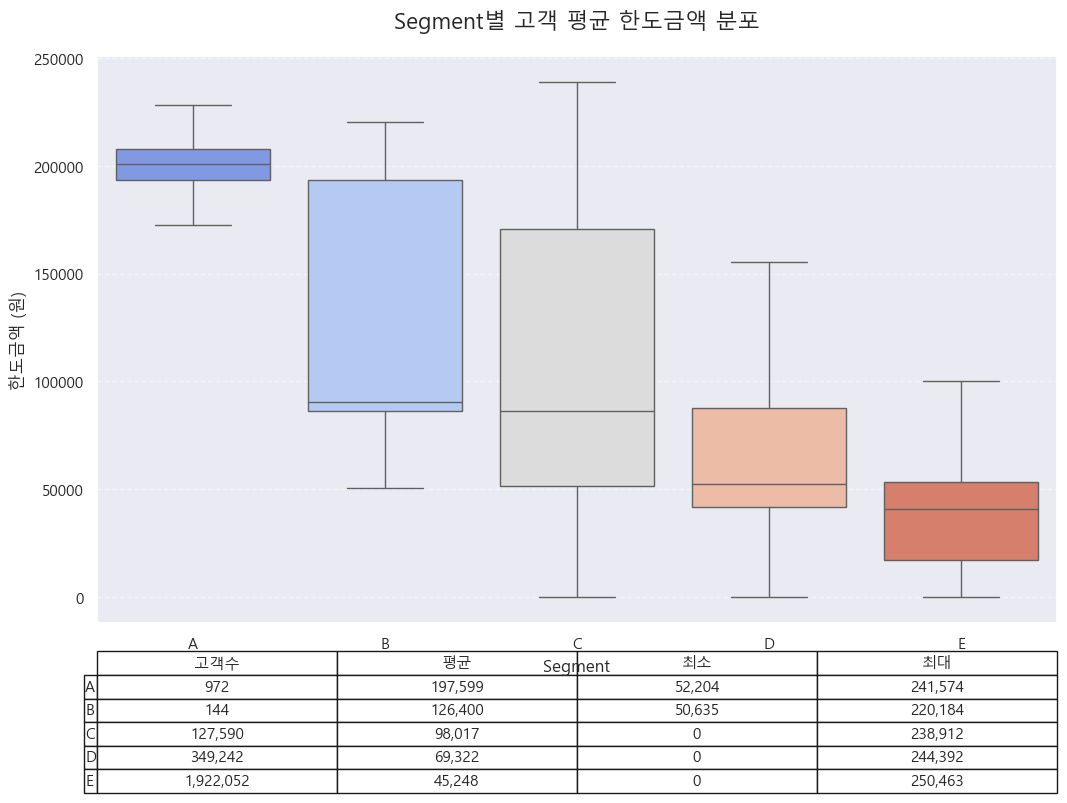

C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\2671730198.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=x_col, y=y_col, data=data,


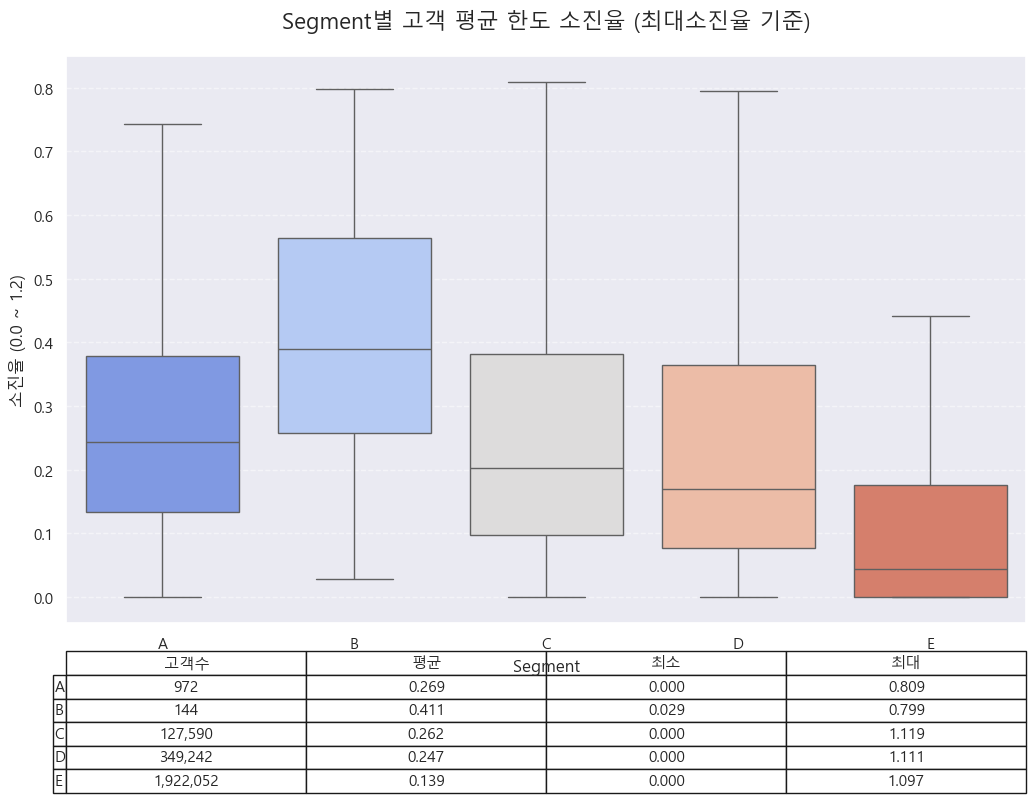

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform

# ---------------------------------------------------------
# 1. 폰트 설정
# ---------------------------------------------------------
system_name = platform.system()
if system_name == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif system_name == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------------------------------------
# 2. [오류 해결] ID 컬럼 복구 (Index -> Column)
# ---------------------------------------------------------
# merged_df가 정의되어 있다고 가정합니다. (이전 셀 실행 결과)

# 'ID'가 컬럼에 없고, 혹시 인덱스 이름이 'ID'라면 리셋
if 'ID' not in df.columns:
    print("⚠️ 'ID' 컬럼이 보이지 않아 인덱스 초기화를 시도합니다...")
    df = df.reset_index()

# 리셋 후에도 'ID'가 없는 경우 (인덱스 이름이 다른 경우 등)
if 'ID' not in df.columns:
    # 혹시 컬럼명이 'index'로 되어있거나 대소문자가 다른지 확인
    print(f"❌ 여전히 'ID' 컬럼이 없습니다. 현재 컬럼 목록: {list(df.columns)}")
    # 만약 'index'라는 컬럼이 생겼고 그게 ID라면 이름 변경
    if 'index' in df.columns:
        print("ℹ️ 'index' 컬럼을 'ID'로 변경합니다.")
        df.rename(columns={'index': 'ID'}, inplace=True)

# ---------------------------------------------------------
# 3. 데이터 집계 및 시각화 재시도
# ---------------------------------------------------------
if 'ID' in df.columns and 'Segment' in df.columns:
    print("✅ ID 컬럼 확보 완료! 집계 및 시각화를 진행합니다.")

    # (1) ID별 평균 계산
    user_stats_df = df.groupby(['ID', 'Segment'], observed=True).agg({
        '카드이용한도금액': 'mean',
        '잔액_신판최대한도소진율_r3m': 'mean'
    }).reset_index()

    user_stats_df.rename(columns={
        '카드이용한도금액': '평균한도금액',
        '잔액_신판최대한도소진율_r3m': '평균소진율'
    }, inplace=True)

    # (2) 시각화 함수 정의
    def plot_segment_analysis(data, x_col, y_col, title, y_label):
        # 순서 정렬
        if data[x_col].dtype.name != 'category':
            data[x_col] = pd.Categorical(data[x_col], categories=['A', 'B', 'C', 'D', 'E'], ordered=True)
        
        # 통계값 계산
        stats = data.groupby(x_col)[y_col].agg(['count', 'mean', 'min', 'max'])
        
        # 그래프
        fig, ax = plt.subplots(figsize=(12, 9))
        sns.boxplot(x=x_col, y=y_col, data=data, 
                    order=['A', 'B', 'C', 'D', 'E'], 
                    palette='coolwarm', showfliers=False, ax=ax)
        
        ax.set_title(title, fontsize=16, pad=20)
        ax.set_ylabel(y_label, fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        
        # 표 추가
        cell_text = []
        for row in stats.values:
            if '소진율' in title:
                formatted_row = [f"{int(row[0]):,}", f"{row[1]:.3f}", f"{row[2]:.3f}", f"{row[3]:.3f}"]
            else:
                formatted_row = [f"{x:,.0f}" if i==0 else f"{x:,.0f}" for i, x in enumerate(row)]
            cell_text.append(formatted_row)
            
        the_table = plt.table(cellText=cell_text,
                              rowLabels=stats.index,
                              colLabels=['고객수', '평균', '최소', '최대'],
                              loc='bottom', cellLoc='center',
                              bbox=[0.0, -0.3, 1.0, 0.25])
        
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(11)
        the_table.scale(1, 1.5)

        plt.subplots_adjust(left=0.1, bottom=0.25)
        plt.show()

    # (3) 실행
    # 한도금액
    plot_segment_analysis(user_stats_df, 'Segment', '평균한도금액', 
                          'Segment별 고객 평균 한도금액 분포', '한도금액 (원)')

    # 소진율 (이상치 Cap)
    user_stats_df['시각화용_소진율'] = user_stats_df['평균소진율'].clip(0, 1.2)
    plot_segment_analysis(user_stats_df, 'Segment', '시각화용_소진율', 
                          'Segment별 고객 평균 한도 소진율 (최대소진율 기준)', '소진율 (0.0 ~ 1.2)')

else:
    print("❌ 오류: 'ID' 또는 'Segment' 컬럼을 찾을 수 없습니다.")
    print(f"현재 컬럼 목록: {list(merged_df.columns)}")

In [17]:
import numpy as np

# ---------------------------------------------------------
# A/B 구분 필살기 파생변수 생성
# ---------------------------------------------------------

# 1. [1차 필터] 우량 고객 후보군 (Premium Candidate)
# 설명: "한도가 5만 원도 안 되면 절대 A, B가 아니다"라는 규칙을 0/1로 박아줍니다.
# 효과: C, D, E 하위 그룹을 1차적으로 걸러냅니다.
threshold_limit = 50000
user_stats_df['우량후보_여부'] = (user_stats_df['평균한도금액'] >= threshold_limit).astype(int)

# 2. [A/B 분리기] 실질 여유 한도 (Real Spare Limit) ★가장 강력함★
# 공식: 평균한도 * (1 - 소진율)
# 설명: "지금 당장 융통할 수 있는 현금 여력"이 얼마인가?
#   - A (부자 & 절약): 한도(大) * 여유(大) = 결과값 [초대형] (예: 13만원)
#   - B (부자 & 낭비): 한도(中) * 여유(小) = 결과값 [중소형] (예: 6만원)
#   - C/D/E: 한도가 작아서 결과값 [소형/영(0)]
user_stats_df['실질여유한도'] = user_stats_df['평균한도금액'] * (1 - user_stats_df['평균소진율'])

# 3. [공격성 지표] 한도 대비 소비성향 (Limit Aggressiveness)
# 공식: 평균소진율 / log(평균한도)
# 설명: 한도가 큰데 소진율까지 높으면(B) 점수가 확 튀게 만듭니다.
#   - A: 분자(소진율)가 낮아서 점수가 낮음 (안정적)
#   - B: 분자(소진율)가 높고 분모(한도)는 A보다 작아서 점수가 높음 (공격적)
# (log를 씌운 이유는 한도 금액의 단위가 너무 커서 소진율이 묻히는 것을 방지하기 위함입니다)
user_stats_df['한도대비_소비성향'] = user_stats_df['평균소진율'] / np.log1p(user_stats_df['평균한도금액'])

# ---------------------------------------------------------
# 생성된 변수 검증 (A와 B가 잘 벌어졌는지 눈으로 확인)
# ---------------------------------------------------------
print("변수 생성 완료! 등급별 평균값 비교:")
check_cols = ['평균한도금액', '평균소진율', '우량후보_여부', '실질여유한도', '한도대비_소비성향']
display(user_stats_df.groupby('Segment')[check_cols].mean().round(4))

변수 생성 완료! 등급별 평균값 비교:


,평균한도금액,평균소진율,우량후보_여부,실질여유한도,한도대비_소비성향
Segment,,,,,
A,197598.8323,0.2694,1.0000,145085.6767,0.0221
B,126400.1250,0.4108,1.0000,77921.2250,0.0355
C,98017.1009,0.2616,0.7928,75935.8600,inf
D,69321.6125,0.2468,0.5877,56116.8822,inf
E,45248.4548,0.1394,0.3458,40933.9013,inf


In [18]:

# 4. 장기 우량 고객 (한도 10만 & 입회 10년 이상 가정)
# '입회경과개월수_신용'이 120개월 이상인 사람
df['장기우량고객'] = ((df['카드이용한도금액'] >= 100000) & (df['입회경과개월수_신용'] >= 120)).astype(int)

# 5. 클린 신용 지표 (최근 1년 카드론/CA 이용 0건)
# B등급과 A등급을 가르는 핵심
df['클린신용지표'] = ((df['이용건수_카드론_R12M'] == 0) & (df['이용건수_CA_R12M'] == 0)).astype(int)

# 6. 할부 의존 지표 (일시불 잔액보다 할부 잔액이 많은 경우)
df['할부의존지표'] = (df['잔액_할부_B0M'] > df['잔액_일시불_B0M']).astype(int)

# ---------------------------------------------------------
# [결과 확인] 등급별 이진화 변수 적중률
# ---------------------------------------------------------
check_bin_cols = ['장기우량고객', '클린신용지표', '할부의존지표']
display(df.groupby('Segment')[check_bin_cols].mean().round(3))

C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\4040194840.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['장기우량고객'] = ((df['카드이용한도금액'] >= 100000) & (df['입회경과개월수_신용'] >= 120)).astype(int)
C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\4040194840.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['클린신용지표'] = ((df['이용건수_카드론_R12M'] == 0) & (df['이용건수_CA_R12M'] == 0)).astype(int)
C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\4040194840.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the

,장기우량고객,클린신용지표,할부의존지표
Segment,,,
A,0.769,0.613,0.282
B,0.208,0.444,0.514
C,0.197,0.652,0.220
D,0.081,0.725,0.217
E,0.027,0.885,0.155


In [19]:
numeric_cols = ['잔액_리볼빙일시불이월_B0M', '잔액_리볼빙CA이월_B0M', '변동률_잔액_B1M', '혜택수혜율_R3M']

for col in numeric_cols:
    if col in df.columns:
        # 문자열을 숫자로 변환 (오류 방지 핵심)
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# 7. 리볼빙_사용여부 (자금 압박 상태 확인)
df['리볼빙_사용여부'] = ((df['잔액_리볼빙일시불이월_B0M'] > 0) | (df['잔액_리볼빙CA이월_B0M'] > 0)).astype(int)

# 8. 잔액_급증신호 (단기 부채 급증 감지)
df['잔액_급증신호'] = (df['변동률_잔액_B1M'] > 0.5).astype(int)

# 9. 혜택_고수혜여부 (체리피커 성향 확인)
benefit_mean = df['혜택수혜율_R3M'].mean()
df['혜택_고수혜여부'] = (df['혜택수혜율_R3M'] > benefit_mean).astype(int)

print("📊 [Segment별 파생변수 비중 요약]")
check_cols = ['리볼빙_사용여부', '잔액_급증신호', '혜택_고수혜여부']

# 등급별 평균값 계산 (해당 특성을 가진 고객의 비율)
result_table = df.groupby('Segment', observed=True)[check_cols].mean()

# % 포맷으로 깔끔하게 출력
display(result_table.round(3).style.format("{:.1%}"))

📊 [Segment별 파생변수 비중 요약]


C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\887937689.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['리볼빙_사용여부'] = ((df['잔액_리볼빙일시불이월_B0M'] > 0) | (df['잔액_리볼빙CA이월_B0M'] > 0)).astype(int)
C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\887937689.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['잔액_급증신호'] = (df['변동률_잔액_B1M'] > 0.5).astype(int)
C:\Users\Brain\AppData\Local\Temp\ipykernel_28176\887937689.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

,리볼빙_사용여부,잔액_급증신호,혜택_고수혜여부
Segment,,,
A,4.3%,0.2%,0.2%
B,8.3%,0.0%,0.0%
C,4.8%,0.7%,0.8%
D,5.4%,0.7%,1.5%
E,2.2%,1.1%,9.7%


In [20]:
#이 코드는 전처리 맨 뒤쪽에 위치해야함

#1. 지나치게 값이 치우친 컬럼 제거 (모든 값이 동일한 컬럼도 여기에 포함)

threshold = 0.95 # 기준 설정 (한 값이 95% 이상 차지하면 불균형으로 간주)
imbalanced_col_names = []

print(f"[데이터 불균형 체크: 비중 {threshold*100}% 이상]")

for col in df.columns:
    if df[col].value_counts(normalize=True).iloc[0] >= threshold:
        imbalanced_col_names.append(col) 

print(f"\n불균형 컬럼 리스트: {imbalanced_col_names}")

#2. 지나치게 결측치가 많은 컬럼 제거
# 컬럼별 결측치 비율 확인 (%) / 50% 이상이면 삭제
missing_ratio = df.isnull().mean() * 100
over_50_missing_cols = missing_ratio[missing_ratio > 50].index.tolist()
print(missing_ratio[missing_ratio > 0].sort_values(ascending=False))


#3. 제거할 컬럼 적용
drop_cols = list(set(over_50_missing_cols) | set(imbalanced_col_names))
df = df.drop(columns=drop_cols)


[데이터 불균형 체크: 비중 95.0% 이상]

불균형 컬럼 리스트: ['소지여부_신용', '회원여부_연체', '탈회횟수_발급6개월이내', '유효카드수_신용_가족', '유효카드수_체크_가족', '이용가능카드수_신용_가족', '이용가능카드수_체크_가족', '이용카드수_신용_가족', '이용카드수_체크_가족', '이용금액_R3M_신용_가족', '이용금액_R3M_체크_가족', '_1순위신용체크구분', '연회비할인카드수_B0M', '기본연회비_B0M', '제휴연회비_B0M', '할인금액_기본연회비_B0M', '할인금액_제휴연회비_B0M', '청구금액_기본연회비_B0M', '청구금액_제휴연회비_B0M', '상품관련면제카드수_B0M', '임직원면제카드수_B0M', '우수회원면제카드수_B0M', '기타면제카드수_B0M', '자발한도감액횟수_R12M', '자발한도감액금액_R12M', '자발한도감액후경과월', '특별한도보유여부_R3M', '연체감액여부_R3M', '한도요청거절건수', '한도심사요청후경과월', '한도심사거절후경과월', '시장단기연체여부_R6M', '시장단기연체여부_R3M', '시장연체상환여부_R6M', '시장연체상환여부_R3M', '이용건수_할부_유이자_B0M', '이용건수_CA_B0M', '이용건수_카드론_B0M', '이용금액_할부_유이자_B0M', '이용금액_CA_B0M', '이용금액_카드론_B0M', '이용후경과월_부분무이자', '이용후경과월_카드론', '이용건수_부분무이자_R12M', '이용금액_부분무이자_R12M', '이용금액_카드론_R12M', '최대이용금액_부분무이자_R12M', '최대이용금액_카드론_R12M', '이용개월수_부분무이자_R12M', '이용건수_부분무이자_R6M', '이용건수_카드론_R6M', '이용금액_카드론_R6M', '이용개월수_부분무이자_R6M', '이용개월수_카드론_R6M', '이용건수_부분무이자_R3M', '이용건수_카드론_R3M', '이용금액_할부_유이자_R3M', '이용금액_카드론_R3M', '이용개월수_부분무이자_R3M'

### 나머지 과정 전처리

In [21]:
# 문자열 관련 부분 제거 혹은 변경
# 직접 확인해봤었던만큼, 상관관계나 분류에 관련된 부분은 찾을 수 없었다.
df = df.drop(['연령', '_2순위신용체크구분', 'Life_Stage', '대표청구지고객주소구분코드', '대표청구서수령지구분코드',
       '청구서수령방법'], axis=1)

In [22]:
train_df = df[df["Segment"].notna()]
test_df = df[df["Segment"].isna()]

In [23]:
# 결측치 확인
print("=== 결측치 현황 ===")
print(train_df.isnull().sum())

# 수정된 결측치 제거 코드
print("\n=== 결측치 제거 시작 ===")
for col in train_df.columns:
    null_count = train_df[col].isnull().sum()
    if null_count > 0:
        mode_value = train_df[col].mode()
        if len(mode_value) > 0:
            # 핵심 변경 부분: 직접 할당
            train_df[col] = train_df[col].fillna(mode_value[0])
            
            # 제대로 채워졌는지 바로 확인
            remaining = train_df[col].isnull().sum()
            print(f"{col}: {null_count} → {remaining} (남은 결측치)")

print(f"\n=== 결측치 제거 완료 ===")
print(f"전체 남은 결측치 개수: {train_df.isnull().sum().sum()}")

=== 결측치 현황 ===
ID                0
남녀구분코드            0
Segment           0
소지카드수_유효_신용       0
소지카드수_이용가능_신용     0
                 ..
0.3이상_총이용금액       0
총이용금액_쇼핑교통여유납부    0
클린신용지표            0
할부의존지표            0
혜택_고수혜여부          0
Length: 486, dtype: int64

=== 결측치 제거 시작 ===
최종유효년월_신용_이용가능: 210447 → 0 (남은 결측치)
최종유효년월_신용_이용: 534231 → 0 (남은 결측치)
최종카드발급일자: 41965 → 0 (남은 결측치)
혜택수혜율_B0M: 555522 → 0 (남은 결측치)
잔여유효개월_실이용: 534231 → 0 (남은 결측치)

=== 결측치 제거 완료 ===
전체 남은 결측치 개수: 0


In [24]:
df.to_parquet("backup.parquet")

In [25]:
df = pd.read_parquet('./backup.parquet') # 본인 경로에 맞게 수정

# 4. Modeling(1) - feature importance

In [26]:
import pandas as pd
import numpy as np
import gc

# from google.colab import drive
# drive.mount('/content/drive')

import sklearn
from sklearn.utils.class_weight import compute_class_weight
import imblearn
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier

In [27]:
df = pd.read_parquet('./backup.parquet') # 본인 경로에 맞게 수정
# 백업파일 명 "backup.parquet"
train_df = df[df["Segment"].notna()]
test_df = df[df["Segment"].isna()]

# 결측치 확인
print("=== 결측치 현황 ===")
print(train_df.isnull().sum())

# 수정된 결측치 제거 코드
print("\n=== 결측치 제거 시작 ===")
for col in train_df.columns:
    null_count = train_df[col].isnull().sum()
    if null_count > 0:
        mode_value = train_df[col].mode()
        if len(mode_value) > 0:
            # 핵심 변경 부분: 직접 할당
            train_df[col] = train_df[col].fillna(mode_value[0])
            
            # 제대로 채워졌는지 바로 확인
            remaining = train_df[col].isnull().sum()
            print(f"{col}: {null_count} → {remaining} (남은 결측치)")

print(f"\n=== 결측치 제거 완료 ===")
print(f"전체 남은 결측치 개수: {train_df.isnull().sum().sum()}")

# 최적화, df 날려버리기 : 백업 파일 있으니 필요하면 사용할 것
del df
gc.collect()

feature_cols = [col for col in train_df.columns if col not in ["ID", "Segment"]]
X = train_df[feature_cols].copy()
y = train_df["Segment"].copy()
y = y.map({'A':0, 'B':1,'C':2,'D':3,'E':4})

del train_df
gc.collect()

=== 결측치 현황 ===
ID                0
남녀구분코드            0
Segment           0
소지카드수_유효_신용       0
소지카드수_이용가능_신용     0
                 ..
0.3이상_총이용금액       0
총이용금액_쇼핑교통여유납부    0
클린신용지표            0
할부의존지표            0
혜택_고수혜여부          0
Length: 486, dtype: int64

=== 결측치 제거 시작 ===
최종유효년월_신용_이용가능: 210447 → 0 (남은 결측치)
최종유효년월_신용_이용: 534231 → 0 (남은 결측치)
최종카드발급일자: 41965 → 0 (남은 결측치)
혜택수혜율_B0M: 555522 → 0 (남은 결측치)
잔여유효개월_실이용: 534231 → 0 (남은 결측치)

=== 결측치 제거 완료 ===
전체 남은 결측치 개수: 0


0

In [28]:
# 클래스 weight 계산
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))

# 각 샘플에 대해 weight 매핑
w_train = pd.Series(y).map(class_weights)

# 전체 feature로 XGBoost 학습 (변수 중요도 추출용)
temp_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=5,
    eval_metric='mlogloss',
    n_estimators=700,
    tree_method='hist',
    device='cuda',
    random_state=42
    )

temp_model.fit(X, y, sample_weight = w_train, verbose=False)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [29]:
# XGBoost 기준 중요도 상위 350개 변수 추출
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': temp_model.feature_importances_
}).sort_values(by='importance', ascending=False)

top350_features = importance_df.head(350)['feature'].tolist()

print(top350_features)

top350_df = pd.DataFrame({'feature': top350_features})
top350_df.to_csv(
    "./data/top350_features_XGB_balanced.csv", # 저장 경로(본인꺼)
    index=False,
    encoding="utf-8-sig"
)

['카드이용한도금액_A수준복합', '선입금원금_B5M', '할부금액_무이자_3M_R12M', '정상청구원금_B5M', '이용금액_체크_B0M', '카드이용한도금액_B1M', '할인금액_청구서_R3M', 'CA한도금액', '정상청구원금_B0M', '이용금액_선결제_R3M', '카드이용한도금액_B2M', '이용금액_R3M_신용체크', '정상청구원금_B2M', '이용개월수_할부_R3M', '방문일수_앱_B0M', '평잔_CA_3M', '최대이용금액_체크_R12M', '이용금액_할부_무이자_R12M', 'rv최초시작후경과일', '탈회횟수_발급1년이내', '이용개월수_할부_무이자_R6M', '이용금액_체크_R12M', '이용금액_CA_R6M', '연체입금원금_B5M', '평잔_할부_3M', '이용여부_CA', '여유_총이용금액', '이용금액_오프라인_B0M', '증감율_이용금액_신용_전월', '이용금액_할부_무이자_B0M', '연속유실적개월수_기본_24M_카드', '건수별평균이용금액_체크_B0M', 'CA이자율_할인전', '입회일자_신용', '카드이용한도금액', '이용개월수_할부_유이자_R6M', '이용개월수_CA_R6M', '할인금액_R3M', '최대이용금액_CA_R12M', '이용개월수_결제일_R6M', '최대이용금액_일시불_R12M', '잔액_현금서비스_B2M', '이용개월수_체크_R12M', '입회경과개월수_신용', '이용카드수_체크', '이용개월수_할부_R12M', '이용건수_신용_R12M', '할부금액_12M_R12M', '이용금액_체크_R6M', '컨택건수_이용유도_LMS_B0M', '강제한도감액금액_R12M', '이용금액_신용_B0M', '상향가능CA한도금액_1여부', '이용후경과월_신용', '할인금액_청구서_B0M', '강제한도감액후경과월', '이용금액_일시불_B0M', '최대이용금액_할부_R12M', '잔액_현금서비스_B1M', '소지카드수_유효_신용', '이용후경과월_신판', 'RV현금서비스이자율_할인전', '이용금액_할부_무이자_R6M', '건수별

# 5. 표준화

In [30]:
top350_df

,feature
0,카드이용한도금액_A수준복합
1,선입금원금_B5M
2,할부금액_무이자_3M_R12M
3,정상청구원금_B5M
4,이용금액_체크_B0M
...,...
345,할부금액_무이자_6M_R12M
346,이용건수_CA_R3M
347,이용건수_신용_R3M
348,이용가능카드수_체크


In [31]:
# 트리모델의 경우, 최적화가 영향을거의 미치지 않아서 굳이 할 필요 없다고 함
# scaler = StandardScaler()
# scaler.fit(df)

# 파일을 따로 저장해서 메모리 사용량을 줄인다.
df= pd.read_parquet("backup.parquet", engine = "fastparquet")
train_df = df.loc[df["Segment"].notna()]
for col in train_df.columns:
    null_count = train_df[col].isnull().sum()
    if null_count > 0:
        mode_value = train_df[col].mode()
        if len(mode_value) > 0:
            # 핵심 변경 부분: 직접 할당
            train_df[col] = train_df[col].fillna(mode_value[0])
            
            # 제대로 채워졌는지 바로 확인
            remaining = train_df[col].isnull().sum()
            print(f"{col}: {null_count} → {remaining} (남은 결측치)")

train_df.to_parquet("train_data.parquet")
df.loc[df["Segment"].isnull()].to_parquet("test_data.parquet")

최종유효년월_신용_이용가능: 210447 → 0 (남은 결측치)
최종유효년월_신용_이용: 534231 → 0 (남은 결측치)
최종카드발급일자: 41965 → 0 (남은 결측치)
혜택수혜율_B0M: 555522 → 0 (남은 결측치)
잔여유효개월_실이용: 534231 → 0 (남은 결측치)


In [32]:
# 최적화 코드
del df
gc.collect()

20

# 6. Modeling(2) - final model train

## XGBoost 모델 학습

In [33]:
import pandas as pd
import numpy as np
import gc
import os

# [수정] 구글 드라이브 마운트 코드 삭제 (로컬에서는 불필요)
# from google.colab import drive
# drive.mount('/content/drive')

import sklearn
from sklearn.utils.class_weight import compute_class_weight
import imblearn
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier

# 현재 버전 및 준비 상태 확인
print(f"XGBoost version: {xgb.__version__}")
print("환경 준비 완료! 이제 데이터를 로드하세요.")

XGBoost version: 3.1.3
환경 준비 완료! 이제 데이터를 로드하세요.


In [34]:
train_df = pd.read_parquet('./train_data.parquet') # 본인 경로에 맞게 수정

feature_cols = [col for col in train_df.columns if col not in ["ID", "Segment"]]
X = train_df[feature_cols].copy()
y = train_df["Segment"].copy()
y = y.map({'A':0, 'B':1,'C':2,'D':3,'E':4})
inverse_label_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E'}

# 변수 350개 사용
top350_df = pd.read_csv("./data/top350_features_XGB_balanced.csv") # 본인 경로에 맞게 수정
top350_features = top350_df['feature'].tolist()
X_top350 = X[top350_features]

# 오버샘플링
smote = SMOTE(sampling_strategy={0: 30000, 1: 30000, 2: 250000}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_top350, y)

# 클래스별 weight 계산
classes = np.unique(y_resampled)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_resampled)
class_weights = dict(zip(classes, weights))
sample_weights = pd.Series(y_resampled).map(class_weights)

for cls in sorted(class_weights):
    print(f"클래스 {cls}: weight = {class_weights[cls]:.2f}")

클래스 0: weight = 17.21
클래스 1: weight = 17.21
클래스 2: weight = 2.07
클래스 3: weight = 1.48
클래스 4: weight = 0.27


In [35]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=5,
    eval_metric='mlogloss',
    n_estimators=5000,
    tree_method='hist',
    device='cuda',
    random_state=42
    )

# 모델 학습 (검증 없이 전체 데이터 사용)
xgb_model.fit(
    X_resampled, y_resampled,
    sample_weight=sample_weights,
    verbose=False
)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [36]:
xgb_model.save_model('./data/softvoting_xgb_xgb변수_3_3_25.json')

## LightGBM 모델 학습

In [37]:
import pandas as pd
import numpy as np
import gc
import sklearn
from sklearn.utils.class_weight import compute_class_weight
import imblearn
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation, LGBMClassifier

# 버전 확인 (이미 설치한 GPU 버전이 잘 나오는지 확인)
print(f"LightGBM 버전: {lgb.__version__}")

# from google.colab import drive
# drive.mount('/content/drive')

# # LightGBM을 위한 GPU driver 설치 코드
# !mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
# !sudo apt install nvidia-driver-460 nvidia-cuda-toolkit clinfo
# !apt-get update --fix-missing
# !pip install -q  lightgbm==4.1.0 \
#   --config-settings=cmake.define.USE_GPU=ON \
#   --config-settings=cmake.define.OpenCL_INCLUDE_DIR="/usr/local/cuda/include/" \
#   --config-settings=cmake.define.OpenCL_LIBRARY="/usr/local/cuda/lib64/libOpenCL.so"

LightGBM 버전: 4.6.0


In [38]:
train_df = pd.read_parquet('./train_data.parquet')

feature_cols = [col for col in train_df.columns if col not in ["ID", "Segment"]]
X = train_df[feature_cols].copy()
y = train_df["Segment"].copy()
y = y.map({'A':0, 'B':1,'C':2,'D':3,'E':4})
inverse_label_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E'}

# 변수 350개 사용
top350_df = pd.read_csv("./data/top350_features_XGB_balanced.csv")
top350_features = top350_df['feature'].tolist()
X_top350 = X[top350_features]

# 오버샘플링
smote = SMOTE(sampling_strategy={0: 30000, 1: 30000, 2: 250000}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_top350, y)

# 클래스별 weight 계산
classes = np.unique(y_resampled)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_resampled)
class_weights = dict(zip(classes, weights))
sample_weights = pd.Series(y_resampled).map(class_weights)

for cls in sorted(class_weights):
    print(f"클래스 {cls}: weight = {class_weights[cls]:.2f}")

클래스 0: weight = 17.21
클래스 1: weight = 17.21
클래스 2: weight = 2.07
클래스 3: weight = 1.48
클래스 4: weight = 0.27


In [39]:
lgb_model = LGBMClassifier(
    objective='multiclass',
    boosting_type = 'gbdt',
    metric = 'multi_logloss',
    verbosity = -1,
    random_state = 42,
    device = 'gpu',
    num_class = 5,
    gpu_platform_id = 0,
    gpu_device_id = 0,

    num_boost_round = 3348, # n_estimators
    learning_rate = 0.16304239034369372,
    num_leaves = 260,
    max_depth = 6,
    min_data_in_leaf = 1200,
    bagging_fraction = 0.8999999999999999,
    bagging_freq = 4,
    feature_fraction = 0.8,
    lambda_l1 = 4.4610495762623494e-05,
    lambda_l2 = 0.6898684039866835,
    min_gain_to_split = 0.3944497642389666
    )

# 모델 학습 (검증 없이 전체 데이터 사용)
lgb_model.fit(
    X_resampled, y_resampled,
    sample_weight=sample_weights,
    callbacks=[
        log_evaluation(period=0)  # ✅ verbose_eval=False랑 같음!
        ]
)

,boosting_type,'gbdt'
,num_leaves,260
,max_depth,6
,learning_rate,0.16304239034369372
,n_estimators,100
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [40]:
lgb_model.booster_.save_model('./data/softvoting_lgbm_model_3_3_25.txt')
print("모델 저장 완료!")

모델 저장 완료!


## CatBoost 모델 학습

In [41]:
import pandas as pd
import numpy as np
import gc

# from google.colab import drive
# drive.mount('/content/drive')

# # catboost 설치
# !pip install catboost

import sklearn
from sklearn.utils.class_weight import compute_class_weight
import imblearn
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
import catboost
from catboost import CatBoostClassifier

print(f"CatBoost 버전: {catboost.__version__}")
print("환경 준비 완료!")

CatBoost 버전: 1.2.8
환경 준비 완료!


In [42]:
train_df = pd.read_parquet('./train_data.parquet')

feature_cols = [col for col in train_df.columns if col not in ["ID", "Segment"]]
X = train_df[feature_cols].copy()
y = train_df["Segment"].copy()
y = y.map({'A':0, 'B':1,'C':2,'D':3,'E':4})
inverse_label_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E'}

# 변수 350개 사용
top350_df = pd.read_csv("./data/top350_features_XGB_balanced.csv")
top350_features = top350_df['feature'].tolist()
X_top350 = X[top350_features]

# 오버샘플링
smote = SMOTE(sampling_strategy={0: 60000, 1: 120000, 2: 240000}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_top350, y)

# 클래스별 weight 계산
classes = np.unique(y_resampled)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_resampled)
class_weights = dict(zip(classes, weights))
sample_weights = pd.Series(y_resampled).map(class_weights)

for cls in sorted(class_weights):
    print(f"클래스 {cls}: weight = {class_weights[cls]:.2f}")

클래스 0: weight = 8.97
클래스 1: weight = 4.49
클래스 2: weight = 2.24
클래스 3: weight = 1.54
클래스 4: weight = 0.28


In [43]:
cat_model = CatBoostClassifier(
    task_type='GPU',
    devices='0',
    random_state=42,
    class_weights=weights.tolist(),
    iterations = 5000
)

# 모델 학습
cat_model.fit(X_resampled, y_resampled)

Learning rate set to 0.085066
0:	learn: 1.4416759	total: 291ms	remaining: 24m 16s
1:	learn: 1.3171966	total: 359ms	remaining: 14m 57s
2:	learn: 1.2198392	total: 431ms	remaining: 11m 57s
3:	learn: 1.1392893	total: 498ms	remaining: 10m 22s
4:	learn: 1.0738807	total: 564ms	remaining: 9m 23s
5:	learn: 1.0162704	total: 629ms	remaining: 8m 43s
6:	learn: 0.9651945	total: 698ms	remaining: 8m 17s
7:	learn: 0.9206766	total: 772ms	remaining: 8m 1s
8:	learn: 0.8818201	total: 844ms	remaining: 7m 48s
9:	learn: 0.8465665	total: 917ms	remaining: 7m 37s
10:	learn: 0.8155882	total: 986ms	remaining: 7m 27s
11:	learn: 0.7872825	total: 1.05s	remaining: 7m 18s
12:	learn: 0.7616112	total: 1.13s	remaining: 7m 13s
13:	learn: 0.7388087	total: 1.2s	remaining: 7m 6s
14:	learn: 0.7170737	total: 1.27s	remaining: 7m 1s
15:	learn: 0.6974870	total: 1.36s	remaining: 7m 3s
16:	learn: 0.6801848	total: 1.43s	remaining: 6m 58s
17:	learn: 0.6635706	total: 1.5s	remaining: 6m 56s
18:	learn: 0.6480563	total: 1.59s	remaining: 6

In [44]:
cat_model.save_model('./data/softvoting_cat_xgb변수_6_12_24.cbm')

# 7. 모델예측 - Soft voting

In [45]:
test_df = pd.read_parquet("./test_data.parquet")

# 변수 350개 사용
top350_df = pd.read_csv("./data/top350_features_XGB_balanced.csv")
top350_features = top350_df['feature'].tolist()

In [46]:
# 학습한 모델들 불러오기
xgb_model_loaded = xgb.XGBClassifier()
xgb_model_loaded.load_model('./data/softvoting_xgb_xgb변수_3_3_25.json')

lgb_model_loaded = lgb.Booster(model_file='./data/softvoting_lgbm_model_3_3_25.txt')

cat_model_loaded = CatBoostClassifier()
cat_model_loaded.load_model('./data/softvoting_cat_xgb변수_6_12_24.cbm')

In [47]:
# test 데이터 준비
X_test = test_df[top350_features]

# XGB predict_proba (iteration_range)
proba_xgb = xgb_model_loaded.predict_proba(X_test, iteration_range=(0, 5000))

# LGB Booster (predict가 proba)
proba_lgb = lgb_model_loaded.predict(X_test, num_iteration=3348)

# CAT predict_proba
proba_cat = cat_model_loaded.predict_proba(X_test)

# soft voting
ensemble_proba = (0.4 * proba_xgb) + (0.3 * proba_lgb) + (0.3 * proba_cat)
ensemble_preds = np.argmax(ensemble_proba, axis=1)
inverse_label_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E'}
ensemble_preds_label = pd.Series(ensemble_preds).map(inverse_label_map)

In [48]:
pred = pd.read_csv("./data/sample_submission.csv")

In [49]:
pred["Segment"] = ensemble_preds_label.iloc[0:100000]
pred.to_csv("./data/submission.csv", index=False)